In [ ]:
import torch
from torch import nn
import torchvision 
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channel=3, out_channel=128):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 4, 2, 1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2),
        self._block(out_channel, out_channel*2, 4, 2, 1),
        self._block(out_channel*2, out_channel*4, 4, 2, 1),
        self._block(out_channel*4, out_channel*8, 4, 2, 1),
        nn.Conv2d(out_channel*8, 1, 4, 2, 0),
        nn.Sigmoid()
    )

  def forward(self, x: torch.tensor):
    return self.disc(x)

  def _block(self, in_channel, out_channel, kernel, stride, padding):
    self.block = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2)
    )
    return self.block

class Generator(nn.Module):
  def __init__(self,z_dim=100, img_channel=3, out_channel=128):
    super().__init__()
    self.gen = nn.Sequential(
        self._block(z_dim, out_channel*8, 4, 2, 0),
        self._block(out_channel*8, out_channel*4, 4, 2, 1),
        self._block(out_channel*4, out_channel*2, 4, 2, 1),
        self._block(out_channel*2, out_channel, 4, 2, 1),
        nn.ConvTranspose2d(out_channel, img_channel,4 ,2 ,1),
        nn.Tanh()
    )

  def forward(self, x: torch.tensor):
    return self.gen(x)

  def _block(self, in_channel, out_channel, kernel, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel, out_channel, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )

class Critic(nn.Module):  # Dont have sigmoid activation att the end 
  def __init__(self, in_channel=3, out_channel=128):
    super().__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 4, 2, 1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2),
        self._block(out_channel, out_channel*2, 4, 2, 1),
        self._block(out_channel*2, out_channel*4, 4, 2, 1),
        self._block(out_channel*4, out_channel*8, 4, 2, 1),
        nn.Conv2d(out_channel*8, 1, 4, 2, 0)
    )

  def forward(self, x: torch.tensor):
    return self.disc(x)

  def _block(self, in_channel, out_channel, kernel, stride, padding):
    self.block = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2)
    )
    return self.block

In [ ]:
disc = Discriminator().to(device)
gen = Generator().to(device)

In [ ]:
x = torch.randn(1, 3, 64, 64).to(device)
x_out = disc(x)
x.shape, x_out.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1, 1, 1, 1]))

In [ ]:
y = torch.rand(1, 100, 1, 1).to(device)
y_out = gen(y)
y.shape, y_out.shape

(torch.Size([1, 100, 1, 1]), torch.Size([1, 3, 64, 64]))

In [ ]:
print(f'{gen}\n-------------------------------------------------')
print(disc)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, 

In [ ]:
# transform = transforms.Compose([
#     transforms.ColorJitter([0.9,0.9]),
#     transforms.RandomGrayscale(p = 0.3),
#     transforms.RandomAffine((-30,30)),
#     transforms.RandomPerspective(),
#     transforms.GaussianBlur(3),
#     transforms.RandomHorizontalFlip(p = 0.2),
#     transforms.RandomVerticalFlip(p = 0.2)
# ])

# data = torchvision.datasets.celeba

In [ ]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
lr = 2e-4
batch_size = 32
img_size = 64
img_channel = 1
z_dim = 100
epochs = 5
disc_feature = 64
gen_feature = 64

transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(img_channel)], [0.5 for _ in range(img_channel)])
    ]
)

datasets = torchvision.datasets.MNIST(root='data',
                                      train=True,
                                      download=True,
                                      transform=transform)
data = torch.utils.data.DataLoader(datasets, 32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
def test():
  N, in_ch, H, W = 32, 1, 64, 64
  z_dim= 100
  x = torch.randn(N, in_ch, H, W)
  disc = Discriminator(in_channel=1, out_channel=128)
  gen = Generator(z_dim=100, img_channel=1, out_channel=128)
  initialize_weights(gen)
  initialize_weights(disc)
  assert disc(x).shape == (N, 1, 1, 1)
  z = torch.randn(N, z_dim, 1, 1)
  assert gen(z).shape == (N, in_ch, H, W)
  print('Success')

test()

Success


In [ ]:
lr = 2e-4
batch_size = 32
img_size = 64
img_channel = 1
z_dim = 100
epochs = 5
disc_feature = 64
gen_feature = 64

disc = Discriminator(in_channel=img_channel).to(device)
gen = Generator(img_channel=img_channel).to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
criterion =nn.BCELoss()

fixed_noise = torch.randn(batch_size, z_dim, 1, 1).to(device)

initialize_weights(gen)
initialize_weights(disc)

In [ ]:
disc.train()
gen.train()

g_loss= []
D_loss = []
fake_img = []

for epoch in range(epochs):
  print(f'Epoch: {epoch} of {epochs}\n------------------')
  for batch, (real, _) in enumerate(data):
    real = real.to(device)
    noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
    fake = gen(noise)

    disc_real = disc(real).reshape(-1) # instead of getting Nx1x1x1 just get N
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake).reshape(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    lossD = (lossD_real + lossD_fake) / 2

    disc.zero_grad()
    lossD.backward(retain_graph=True)
    disc_opt.step()

    output = disc(fake).reshape(-1)
    lossG = criterion(output, torch.ones_like(output))

    gen.zero_grad()
    lossG.backward()
    gen_opt.step()

    if batch % 100 == 0:
      print(f'batch {batch} of {len(data)}')

      g_loss.append(lossG)
      D_loss.append(lossD)

    if batch % 500 == 0:
      fake_image = gen(fixed_noise)
      fake_img.append(fake_image)


Epoch: 0 of 5
------------------
batch 0 of 1875
batch 100 of 1875
batch 200 of 1875
batch 300 of 1875
batch 400 of 1875
batch 500 of 1875
batch 600 of 1875
batch 700 of 1875
batch 800 of 1875
batch 900 of 1875
batch 1000 of 1875
batch 1100 of 1875
batch 1200 of 1875
batch 1300 of 1875
batch 1400 of 1875
batch 1500 of 1875
batch 1600 of 1875
batch 1700 of 1875
batch 1800 of 1875
Epoch: 1 of 5
------------------
batch 0 of 1875
batch 100 of 1875
batch 200 of 1875
batch 300 of 1875
batch 400 of 1875
batch 500 of 1875
batch 600 of 1875
batch 700 of 1875
batch 800 of 1875
batch 900 of 1875
batch 1000 of 1875
batch 1100 of 1875
batch 1200 of 1875
batch 1300 of 1875
batch 1400 of 1875
batch 1500 of 1875
batch 1600 of 1875
batch 1700 of 1875
batch 1800 of 1875
Epoch: 2 of 5
------------------
batch 0 of 1875
batch 100 of 1875
batch 200 of 1875
batch 300 of 1875
batch 400 of 1875
batch 500 of 1875
batch 600 of 1875
batch 700 of 1875
batch 800 of 1875
batch 900 of 1875
batch 1000 of 1875
batch 

RuntimeError: ignored

In [ ]:
fake_img[1].shape

torch.Size([32, 1, 64, 64])

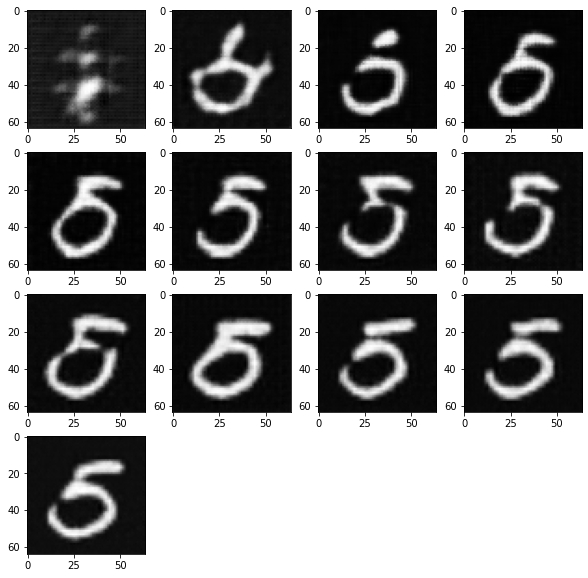

In [ ]:
fig = plt.figure(figsize=(10, 10))
row, cols = 4, 4
for i in range(1, 14):
  fig.add_subplot(row, cols, i)
  plt.imshow(fake_img[i][22].to('cpu').detach().squeeze().numpy(), cmap='gray')

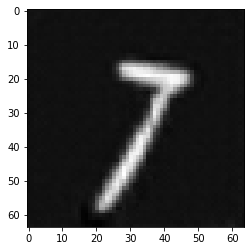

In [ ]:
img = gen(fixed_noise)
plt.imshow(img[][0].to('cpu').detach().squeeze().numpy(), cmap='gray')

In [ ]:
####. wGAN

lr = 5e-5
batch_size = 64
img_size = 64
img_channel = 1
z_dim = 100
epochs = 5
critic_iterations = 5
weight_clip = 0.01  # C parameter in the paper


critic = Critic(in_channel=img_channel, out_channel=128).to(device)
gen = Generator(z_dim=100, img_channel=img_channel, out_channel=128).to(device)

gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr)
critic_opt = torch.optim.RMSprop(critic.parameters(), lr=lr)

fixed_noise = torch.randn(batch_size, z_dim, 1, 1).to(device)

initialize_weights(gen)
initialize_weights(critic)

In [ ]:
critic.train()
gen.train()

g_loss= []
D_loss = []
fake_img = []

for epoch in range(epochs):
  print(f'Epoch: {epoch+1} of {epochs}\n------------------')
  for batch, (real, _) in enumerate(data):
    real = real.to(device)

    for _ in range(critic_iterations):
      noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
      fake = gen(noise)
      critic_real = critic(real).reshape(-1) # instead of getting Nx1x1x1 just get N
      critic_fake = critic(fake).reshape(-1)
      loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake)) # - for maximize

      critic.zero_grad()
      loss_critic.backward(retain_graph=True)
      critic_opt.step()
      # for p in critic.parameters():
      #   p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)


    output = critic(fake).reshape(-1)
    lossG = -torch.mean(output)

    gen.zero_grad()
    lossG.backward()
    gen_opt.step()

    if batch % 100 == 0:
      print(f'batch {batch} of {len(data)}')

      g_loss.append(lossG)
      D_loss.append(loss_critic)

    if batch % 500 == 0:
      fake_image = gen(fixed_noise)
      fake_img.append(fake_image)


Epoch: 1 of 5
------------------
batch 0 of 1875
batch 100 of 1875
batch 200 of 1875
batch 300 of 1875
batch 400 of 1875
batch 500 of 1875
batch 600 of 1875
batch 700 of 1875
batch 800 of 1875
batch 900 of 1875
batch 1000 of 1875


KeyboardInterrupt: ignored

IndexError: ignored

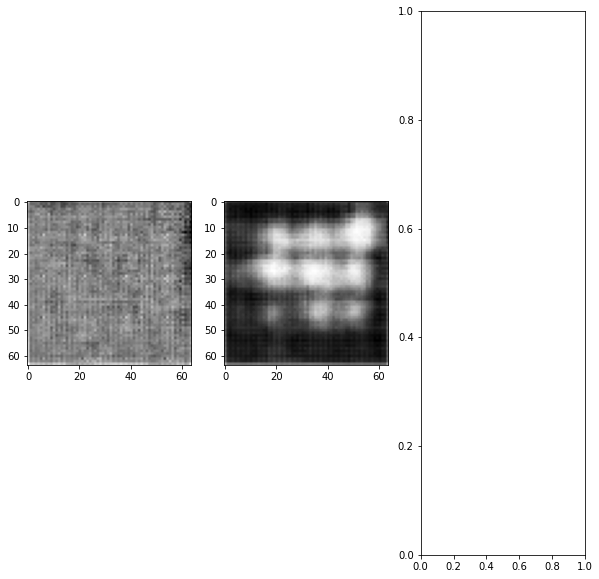

In [ ]:
fig = plt.figure(figsize=(10, 10))
row, cols = 1, 3
for i in range(1, 4):
  fig.add_subplot(row, cols, i)
  plt.imshow(fake_img[i][2].to('cpu').detach().squeeze().numpy(), cmap='gray')

In [ ]:
len(fake_img)

3